In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression


In [7]:
df = pd.read_csv("/Users/vatti/explain-my-model/data/heart copy.csv")

In [8]:
# Quick look
print(df.head())
print(df.info())
print(df.describe())

   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age    

In [9]:
# Check for nulls
print(df.isnull().sum())

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


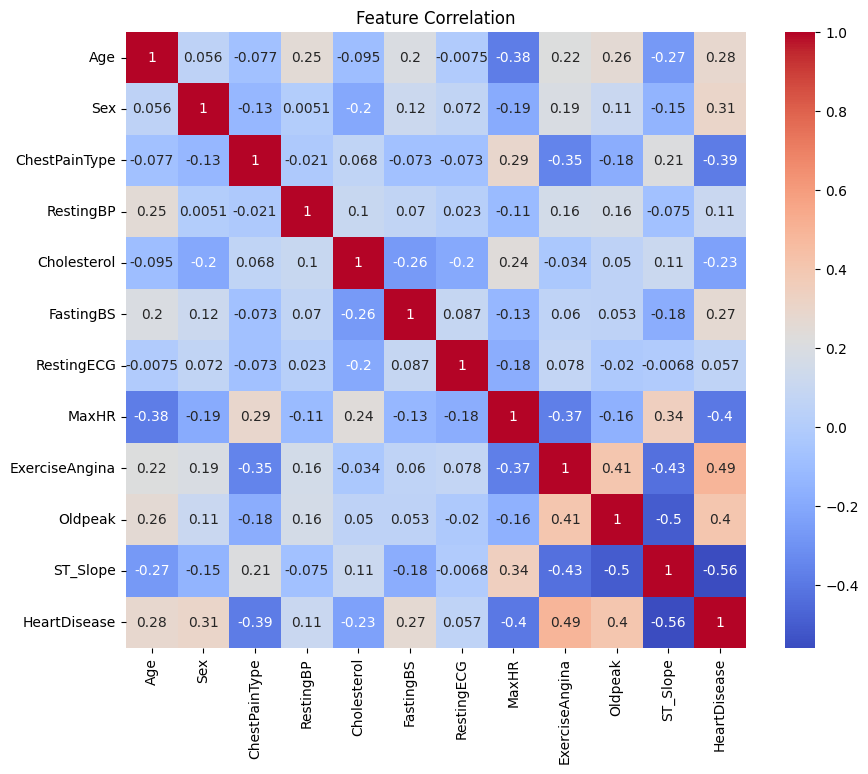

In [11]:
# Encode categorical features temporarily
df_encoded = df.copy()
for col in df_encoded.select_dtypes(include='object').columns:
    df_encoded[col] = df_encoded[col].astype('category').cat.codes

# Now plot correlation
plt.figure(figsize=(10, 8))
sns.heatmap(df_encoded.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation")
plt.show()


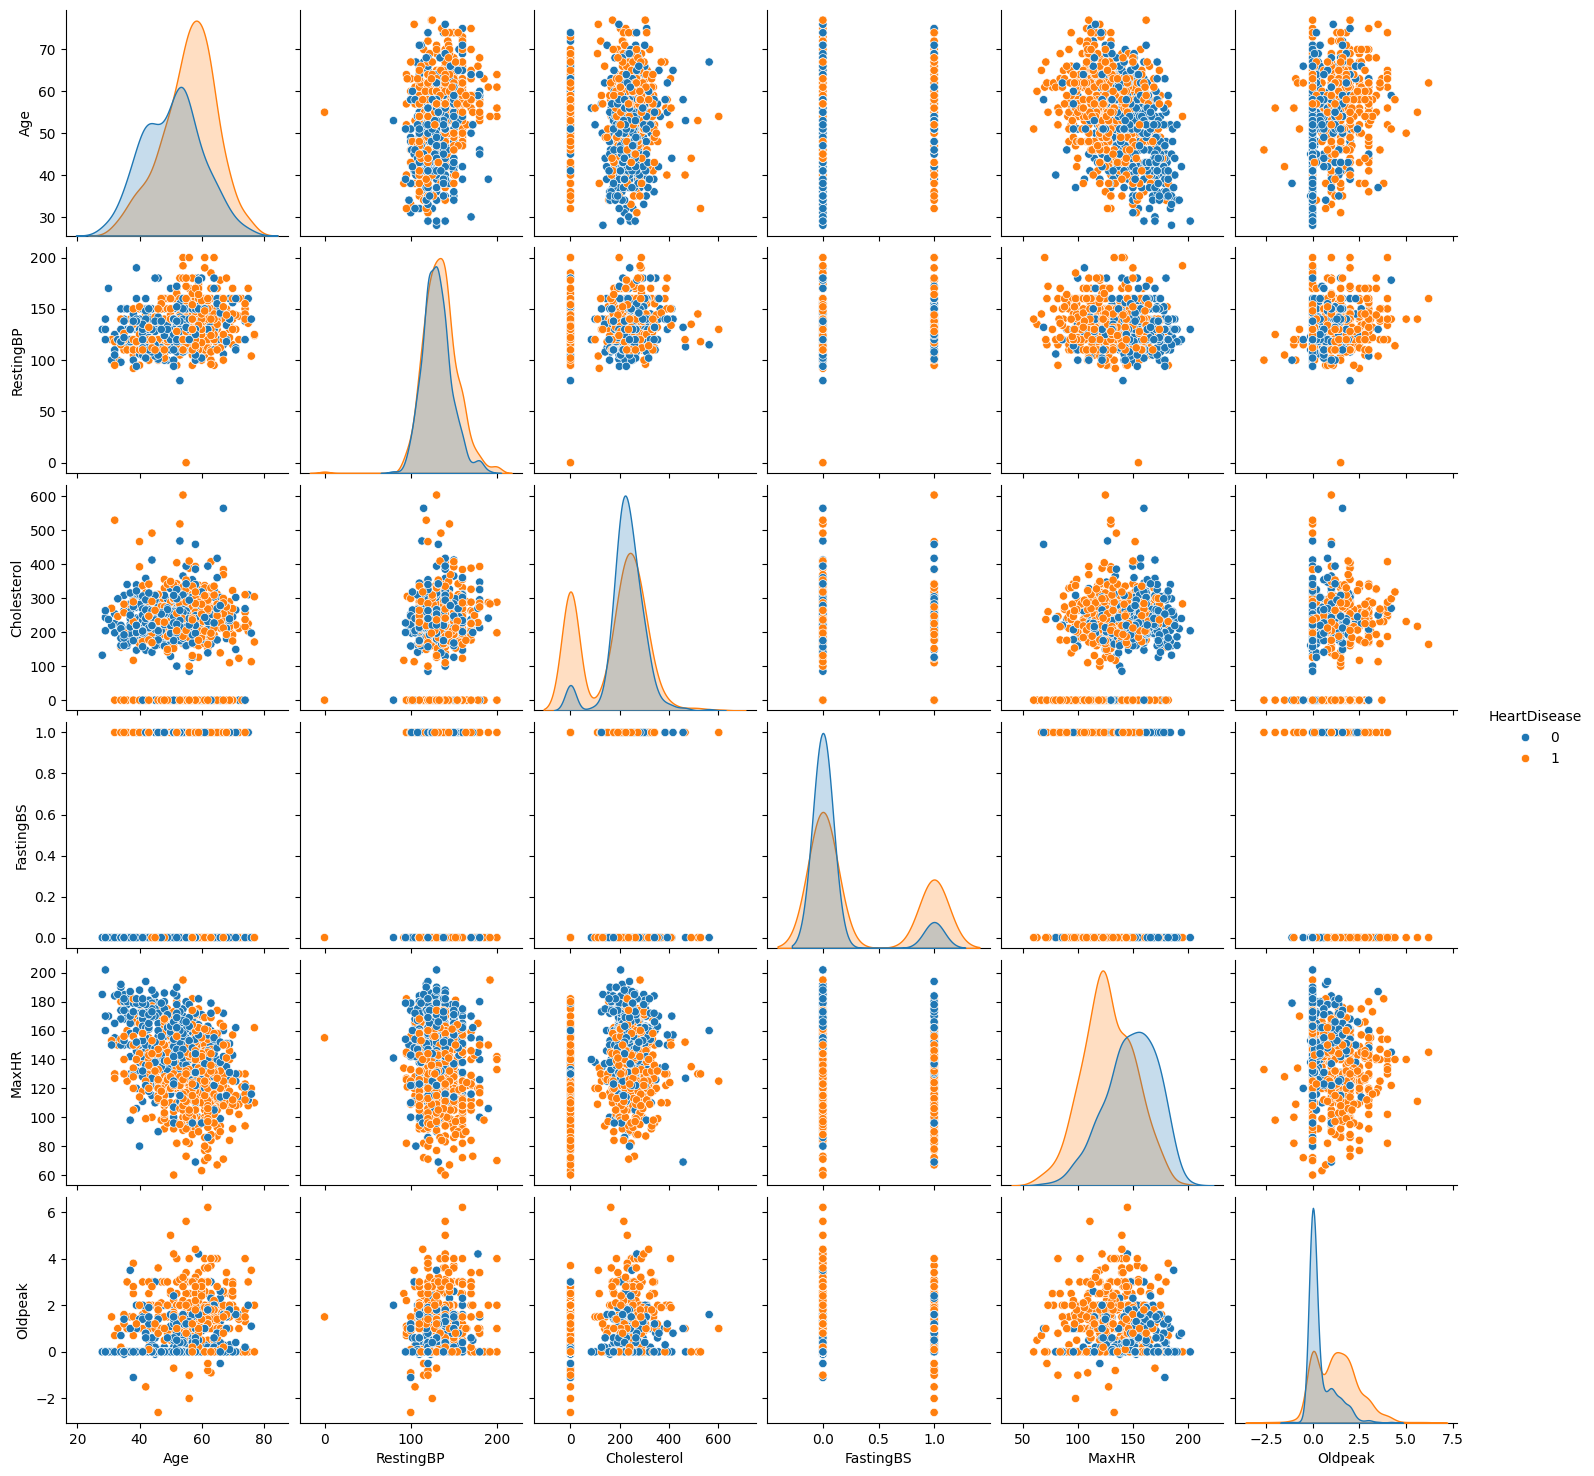

In [12]:
# Pairplot
sns.pairplot(df, hue="HeartDisease")
plt.show()

In [37]:
# Encode categorical variables
df_encoded = df.copy()

# Identify categorical columns
cat_cols = df.select_dtypes(include=['object']).columns
print("Categorical columns:", cat_cols.tolist())

# Option 1: Label encoding for binary columns (e.g., M/F)
for col in cat_cols:
    if df_encoded[col].nunique() == 2:
        df_encoded[col] = df_encoded[col].map({df[col].unique()[0]: 0, df[col].unique()[1]: 1})
    else:
        # Option 2: One-hot encode for >2 categories
        df_encoded = pd.get_dummies(df_encoded, columns=[col], drop_first=True)


Categorical columns: ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']


In [38]:
# Split features and target
X = df_encoded.drop("HeartDisease", axis=1)
y = df_encoded["HeartDisease"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [39]:
# Train Logistic Regression
logreg = LogisticRegression(max_iter=1000)  # increase iterations
logreg.fit(X_train_scaled, y_train)
y_pred_lr = logreg.predict(X_test_scaled)
print("Logistic Regression Results:")
print(classification_report(y_test, y_pred_lr))

Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.80      0.87      0.83        77
           1       0.90      0.84      0.87       107

    accuracy                           0.85       184
   macro avg       0.85      0.86      0.85       184
weighted avg       0.86      0.85      0.85       184



/Users/vatti/explainer-env/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/vatti/explainer-env/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/vatti/explainer-env/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/vatti/explainer-env/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Users/vatti/explainer-env/lib/python3.9/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: overflow encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * 

In [40]:
# Train XGBoost on unscaled data (preferred)
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss")
xgb_clf.fit(X_train, y_train)
y_pred_xgb = xgb_clf.predict(X_test)
print("XGBoost Results:")
print(classification_report(y_test, y_pred_xgb))

XGBoost Results:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84        77
           1       0.89      0.87      0.88       107

    accuracy                           0.86       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.87      0.86      0.86       184



/Users/vatti/explainer-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:29:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [41]:
# SHAP Explanation
explainer = shap.Explainer(xgb_clf)
shap_values = explainer(X_test)

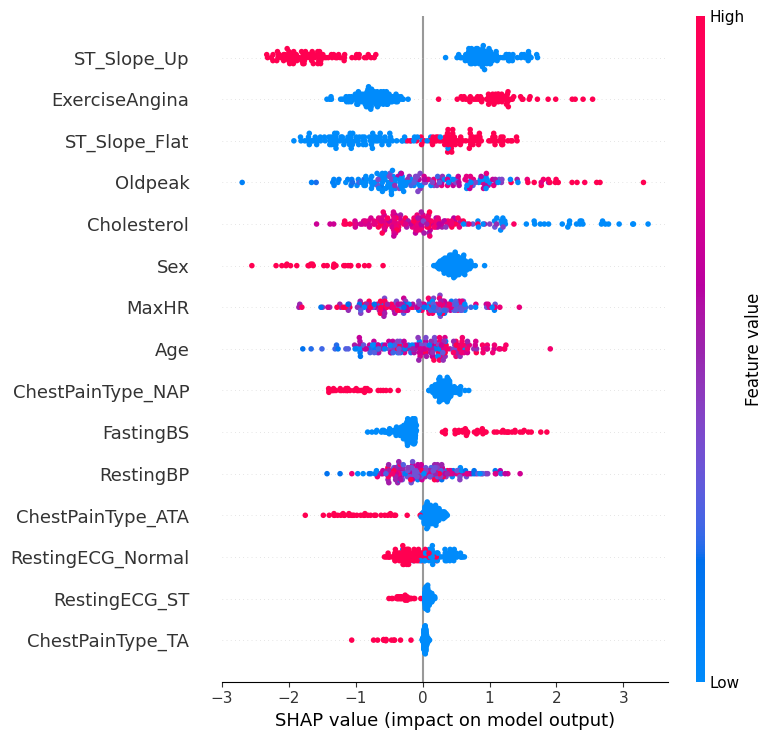

In [42]:
# SHAP Summary plot
shap.summary_plot(shap_values, X_test)


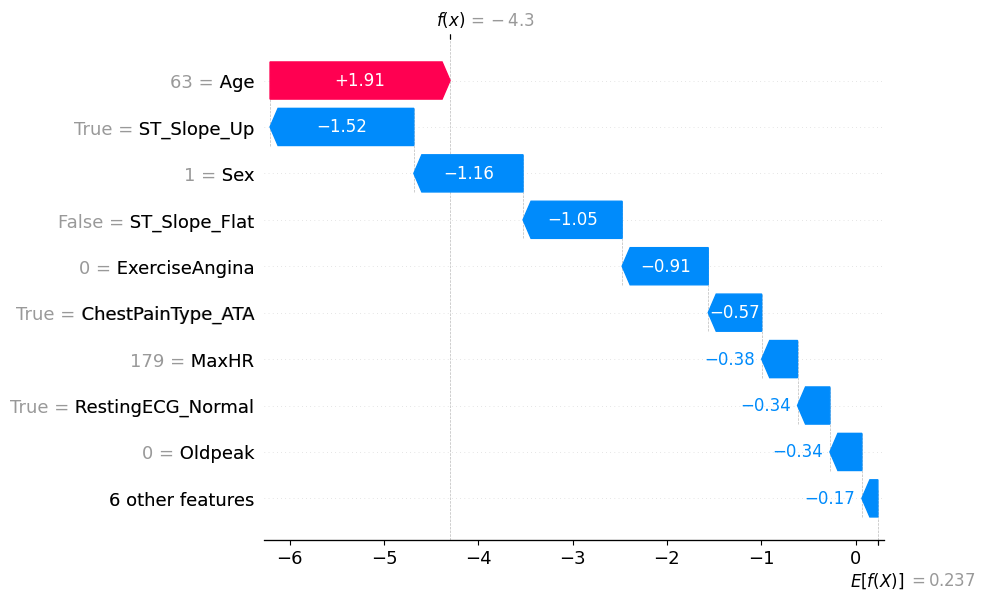

In [43]:
# SHAP for single prediction
shap.plots.waterfall(shap_values[0])
